# Machine Learning Applications for Health (COMP90089_2022_SM2)
# Tutorial 3: Digital Phenopything using MIMIC-IV data.

MIMIC-IV is a publicly accessible clinical database containing comprehensive information for hospital stays of over 60,000 patients. 

You can read more about MIMIC-IV from the following resources:

* [The MIMIC-IV PhysioNet project page](https://physionet.org/content/mimiciv/)
* [The MIMIC-IV online documentation](https://mimic-iv.mit.edu)

This notebook assumes that you have access to MIMIC-IV on Google BigQuery. If you're not sure if you do, or would like to apply for access, head over to the [MIMIC-IV access page](https://mimic-iv.mit.edu/docs/access/) for instructions.


* **Goals**

Select a cohort for a disease, based on the diagnosis criteria.

* **Definitions**

Disease: Acute Kidney Injury.

Disease criteria source: Kidney Disease Improving Global Outcomes (KDIGO) [definition.](https://www.uptodate.com/contents/definition-and-staging-criteria-of-acute-kidney-injury-in-adults?search=acute%20kidney%20injury&source=search_result&selectedTitle=3~150&usage_type=default&display_rank=2)


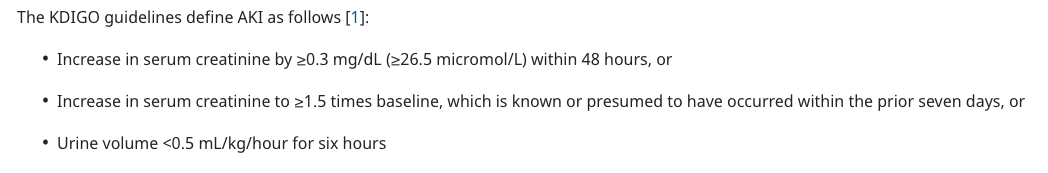

## Load libraries and setup environment

In [1]:
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

We need to authenticate this notebook with Google Cloud Platform (GCP) in order to query MIMIC-IV. When prompted to login, **make sure you use the Google account granted access to MIMIC-IV via PhysioNet**. [Details on granting your Google account access are described in the online documentation](https://mimic-iv.mit.edu/docs/access/cloud/).

In [2]:
# authenticate
auth.authenticate_user()

Next up, our final piece of configuration. In order to query the data, we need to **set the project ID**. **Please check your project ID in BigQuery and replace in the code below.**

If you're not sure what your project ID is, or if you haven't made a project on GCP, [you can read about creating and managing google projects here](https://cloud.google.com/resource-manager/docs/creating-managing-projects). Afterwards, change the `project_id` variable below to your Google project.

In [5]:
# Set up environment variables
project_id = 'CHANGE-ME'
if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project.')
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
# if you want to use the demo, change this to mimic_demo
dataset = 'mimiciv'


ValueError: ignored

Find the **"serum creatinine"** and **"urine volume"** in the Label columns inside the dictionary of Laboratory tests and get the corresponding itemid code.
* For the module hosp, 3 items of itemid were found: 51081, 51108, 51109
* For the module icu, 2 items of itemid were found: 220615, 226559


In [4]:
##Module hosp:
df = run_query("""
SELECT label, itemid
FROM `physionet-data.mimiciv_hosp.d_labitems`
WHERE label LIKE "Creatinine%Serum" OR label LIKE "Urine%"
""")
print(df)

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



GenericGBQException: ignored

In [ ]:
##Module icu:
df2 = run_query("""
SELECT *
FROM `physionet-data.mimiciv_icu.d_items`
WHERE label LIKE "%Creatinine%" OR label LIKE "Foley%"
""")
print(df2)

If the above raises an error, you'll need to double check you've set your project correctly, and ensure that you have [requested access to MIMIC-IV on Google BigQuery via the PhysioNet project page](https://mimic-iv.mit.edu/docs/access/cloud/#accessing-mimic-iv-on-the-cloud).


# Patients Information

After discovering the item id codes, get all patient ids that have those lab tests. You can find for each module and merge the results. But here we will keep with only a single module result.

* Module hosp, tables labevents and d_labitems. Get all patients data with those 3 lab tests (51081,51108,51109).

In [ ]:
##Module hosp:
query = f"""
SELECT le.*,dlab.label, dlab.fluid
FROM `physionet-data.mimiciv_hosp.labevents` AS le
INNER JOIN `physionet-data.mimiciv_hosp.d_labitems` AS dlab
  ON le.itemid = dlab.itemid
WHERE le.itemid in (51081,51108,51109)
ORDER BY subject_id
"""
pt = run_query(query)
pt

* Module **icu, table outputevents**. Also get patient weight information from omr table: (More than 1 measurement for patient.). Get all patients data with the lab test **"Foley" (Urine)** 226559.

In [ ]:
##Module icu, table outputevents. Also get patient weight information from omr table: (More than 1 measurement for patient.)
query = f"""
SELECT le.*,dlab.label,omr.result_value
FROM `physionet-data.mimiciv_icu.outputevents` AS le
INNER JOIN `physionet-data.mimiciv_icu.d_items` AS dlab
 ON le.itemid = dlab.itemid
INNER JOIN `physionet-data.mimiciv_hosp.omr` AS omr
 ON le.subject_id = omr.subject_id
WHERE le.itemid = 226559 AND omr.result_name = 'Weight (Lbs)'
ORDER BY subject_id
"""
pt2 = run_query(query)
pt2

* Module **icu, table charevents**. Get all patients data with the lab test "**Creatinine (serum)**" 220615.

In [ ]:
##Module icu, table chartevents, Patients with info Creatinine (serum):
query = f"""
SELECT char.*,dlab.label
FROM `physionet-data.mimiciv_icu.chartevents` AS char
INNER JOIN `physionet-data.mimiciv_icu.d_items` AS dlab
 ON char.itemid = dlab.itemid
WHERE char.itemid = 220615
ORDER BY subject_id
"""
pt3 = run_query(query)
pt3

#  **What's next?** 

Now that you have downloaded all the patients list with Creatinine (serum) test, you need to apply some filters in order to meet the diagnosis criteria: **`Increase in serum creatinine by ≥0.3 mg/dL (≥26.5 micromol/L) within 48 hours.`**

In [ ]:
## Create a dataframe copy to work with. Keep entries with 2 or more info (to compare date difference).
import warnings
warnings.filterwarnings('ignore')

icu_creatinine = pt3.copy()

## Transform the value column Dtype in float: (it's current an object)
icu_creatinine['value'] = icu_creatinine['value'].astype(np.float64)

## Find only patients with 2 or more data, so you can compare a time difference between them.
keep_duplicated = icu_creatinine.duplicated(subset='subject_id',keep=False)
icu_creatinine['duplicated'] = keep_duplicated
icu_creatinine = icu_creatinine[icu_creatinine['duplicated']==True]
del icu_creatinine['duplicated']

## Sort the dataframe by ascending order time using the column 'charttime'. 
ic_sorted = icu_creatinine.sort_values(by='charttime')
ic_sorted.reset_index(inplace=True, drop=True)

# Get the unique list of patient's id within the final set to iterate over them in the next section code.
patients = list(ic_sorted['subject_id'].unique())
print(patients)

  

In [ ]:
# Limit the size of patients list for time purposes
patients = patients[0:20] 
print(patients)

subset = pd.DataFrame()
found_subset = pd.DataFrame()

# Check for each patient id: the time difference between each entry (transform it to hours) and the Creatinine delta too. 

for each in patients:

  subset = ic_sorted.loc[ic_sorted['subject_id'] == each].reset_index(drop=True)

  subset['Diff_Time_Hours'] = subset["charttime"].diff().dt.total_seconds() / 60 / 60
  subset['Diff_Creatinine'] = subset["value"].diff()

# Create a new dataframe for the patients meeting the diagnosis criteria:

  if not subset.loc[(subset['Diff_Creatinine'] >= 0.3) & (subset['Diff_Time_Hours'] <= 48)].empty:

    found_subset = found_subset.append(subset)
print(found_subset)



